# Day 08. Exercise 02
# Multiclass classification. One-hot encoding. Random forest

## 0. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## 1. Preprocessing

1. Read the file [`checker-submits.csv`](https://drive.google.com/file/d/14voc4fNJZiLEFaZyd8nEG-lQt5JjatYw/view?usp=sharing).
2. Create a dataframe `df` with the columns: `uid`, `labname`, `numTrials`, `hour`, `dayofweek` where `hour` is extracted from the `timestamp` as well as the `dayofweek` (`0` is Monday, `6` is Sunday). We will try to predict the day of the week having data about which user made a commit for which lab at which hour and which try it was.
3. Using `OneHotEncoder()` transform your categorical features, delete from the dataframe the initial columns.
4. Use `StandardScaler()` and scale your continuous features.
5. Save the dataframe as `dayofweek.csv`.
6. Before trying out different algorithms, find out the accuracy of the naive algorithms – the one that predicts everything as the most popular class.

In [2]:
df_raw = pd.read_csv("../data/checker_submits.csv")

In [3]:
df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])
df = pd.DataFrame({
    'uid': df_raw['uid'],
    'labname': df_raw['labname'],
    'numTrials': df_raw['numTrials'],
    'hour': df_raw['timestamp'].dt.hour,
    'dayofweek': df_raw['timestamp'].dt.dayofweek
})

In [4]:
ohe = OneHotEncoder(sparse_output=False)
cat_features = ohe.fit_transform(df[['uid', 'labname']])
cat_feature_names = ohe.get_feature_names_out(['uid', 'labname'])

In [5]:
df_ohe = pd.DataFrame(cat_features, columns=cat_feature_names)

In [6]:
df_final = pd.concat([df_ohe, df[['numTrials', 'hour', 'dayofweek']].reset_index(drop=True)], axis=1)

In [7]:
scaler = StandardScaler()
df_final[['numTrials', 'hour']] = scaler.fit_transform(df_final[['numTrials', 'hour']])

In [8]:
df_final.to_csv("../data/dayofweek.csv", index=False)

In [9]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1686 entries, 0 to 1685
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid_user_0        1686 non-null   float64
 1   uid_user_1        1686 non-null   float64
 2   uid_user_10       1686 non-null   float64
 3   uid_user_11       1686 non-null   float64
 4   uid_user_12       1686 non-null   float64
 5   uid_user_13       1686 non-null   float64
 6   uid_user_14       1686 non-null   float64
 7   uid_user_15       1686 non-null   float64
 8   uid_user_16       1686 non-null   float64
 9   uid_user_17       1686 non-null   float64
 10  uid_user_18       1686 non-null   float64
 11  uid_user_19       1686 non-null   float64
 12  uid_user_2        1686 non-null   float64
 13  uid_user_20       1686 non-null   float64
 14  uid_user_21       1686 non-null   float64
 15  uid_user_22       1686 non-null   float64
 16  uid_user_23       1686 non-null   float64


In [10]:
X = df_final.drop(columns=['dayofweek'])
y = df_final['dayofweek']

In [11]:
most_common = y.mode()[0]
acc_naive = accuracy_score(y, [most_common] * len(y))
print("Naive accuracy:", acc_naive)

Naive accuracy: 0.23487544483985764


## 2. Algorithms

### a. Logreg

1. Train logistic regression, for the baseline model use `random_state=21`, `fit_intercept=False`. 
2. Calculate the accuracy.
3. Write a function that draws the plot (`barh`) taking coefficients of any trained models, names of the features and the number of `top-n` most important features to display.
4. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model.
5. Remember that it is a multiclass classification and `coef_` returns a matrix, to calculate importance for a feature you need to sum all the individual feature importances for all the target values.

In [12]:
logreg = LogisticRegression(random_state=21, fit_intercept=False)
logreg.fit(X, y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,False
,intercept_scaling,1
,class_weight,None
,random_state,21
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [13]:
y_pred = logreg.predict(X)
acc_logreg = accuracy_score(y, y_pred)
print("LogReg accuracy:", acc_logreg)

LogReg accuracy: 0.6405693950177936


In [14]:
def plot_feature_importance(coefs, feature_names, top_n=10, title="Feature importance"):
    importance = np.sum(np.abs(coefs), axis=0)
    idx = np.argsort(importance)[-top_n:]
    plt.barh(range(top_n), importance[idx], align='center')
    plt.yticks(range(top_n), [feature_names[i] for i in idx])
    plt.title(title)
    plt.show()

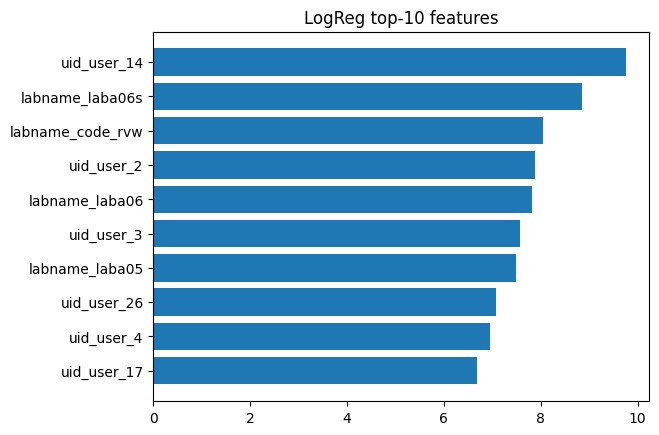

In [15]:
plot_feature_importance(logreg.coef_, X.columns, top_n=10, title="LogReg top-10 features")

In [16]:
importance = np.sum(np.abs(logreg.coef_), axis=0)
sorted_idx = np.argsort(importance)[::-1]
for i in range(10):
    print(X.columns[sorted_idx[i]], importance[sorted_idx[i]])


uid_user_14 9.755181649432249
labname_laba06s 8.85557750994732
labname_code_rvw 8.05153572170073
uid_user_2 7.88962976237901
labname_laba06 7.809795739189778
uid_user_3 7.567022573869802
labname_laba05 7.496375583013116
uid_user_26 7.084832857564514
uid_user_4 6.953175955394825
uid_user_17 6.685331541378394


### b. SVC

1. Train a `SVC` model, for the baseline model use parameters `kernel='linear'`, `probability=True`, `random_state=21`. 
2. Try different kernels, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model for the linear kernel *

*By default SVC uses “one vs one” strategy of the classification, thus in `coef_` it returns a matrix. To calculate importance for a feature you need to use [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) over the SVC and sum all the individual feature importances for all the target values.

In [17]:
svc = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=21))
svc.fit(X, y)
y_pred = svc.predict(X)
acc_svc = accuracy_score(y, y_pred)
print("SVC (linear) accuracy:", acc_svc)

SVC (linear) accuracy: 0.6126927639383155


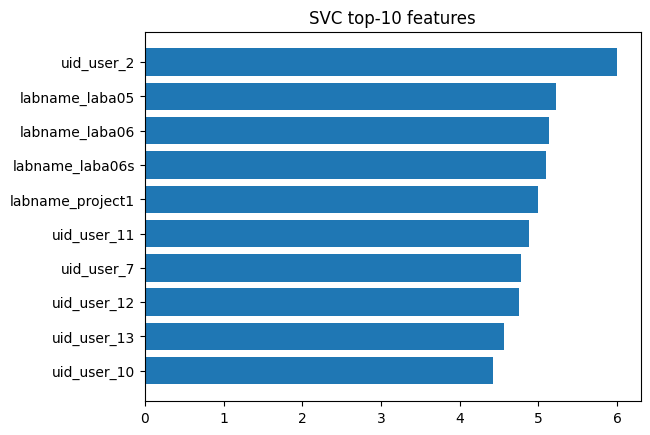

In [18]:
coefs = np.array([est.coef_[0] for est in svc.estimators_])
plot_feature_importance(coefs, X.columns, top_n=10, title="SVC top-10 features")

### c. Decision tree

1. Train a `DecisionTreeClassifier` using for the baseline model `max_depth=4`, `random_state=21`. 
2. Try different values of `max_depth`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [19]:
dt = DecisionTreeClassifier(max_depth=4, random_state=21)
dt.fit(X, y)
y_pred = dt.predict(X)
acc_dt = accuracy_score(y, y_pred)
print("Decision Tree accuracy:", acc_dt)

Decision Tree accuracy: 0.5516014234875445


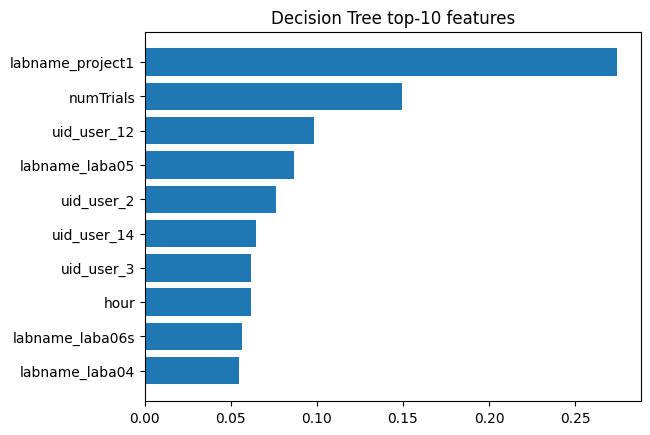

In [20]:
plot_feature_importance([dt.feature_importances_], X.columns, top_n=10, title="Decision Tree top-10 features")

### d. Random forest

In real life forest is a set of trees. The same thing is with machine learning. Random forest is a set of individual decision trees (check the documentation for more details).

1. Train a `RandomForestClassifier` using for the baseline model parameters `n_estimators=100`, `max_depth = 25`, `random_state=21`. 
2. Try different values of `max_depth` and `n_estimators`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [21]:
rf = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=21)
rf.fit(X, y)
y_pred = rf.predict(X)
acc_rf = accuracy_score(y, y_pred)
print("Random Forest accuracy:", acc_rf)

Random Forest accuracy: 0.9994068801897983


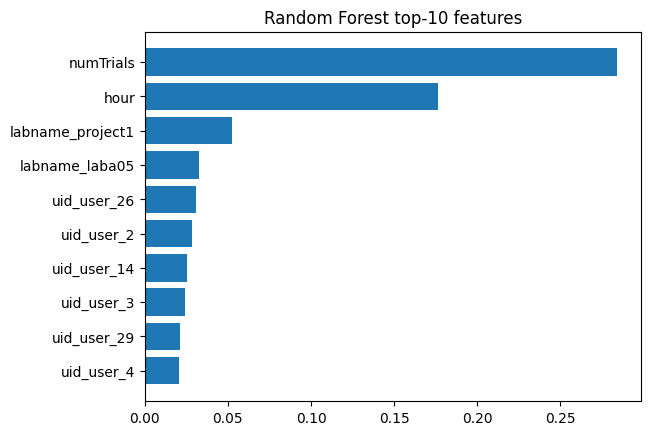

In [22]:
plot_feature_importance([rf.feature_importances_], X.columns, top_n=10, title="Random Forest top-10 features")

## result
- Naive classifier accuracy: 0.23487544483985764
- Logistic regression accuracy: 0.6405693950177936
- SVC accuracy (best kernel): 0.6126927639383155
- Decision Tree accuracy: 0.5516014234875445
- Random Forest accuracy: 0.9994068801897983

Random Forest оказался самым точным среди протестированных моделей.
